In [2]:
import faiss
import glob
from itertools import chain
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.spatial import distance
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from style_stack import StyleStack
from utils import get_concatenated_images, load_image, plot_results

from IPython.core.debugger import set_trace

/home/theaustinator/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Semantic Similarity Search

Classifiers

### Dataset Labeled by Style

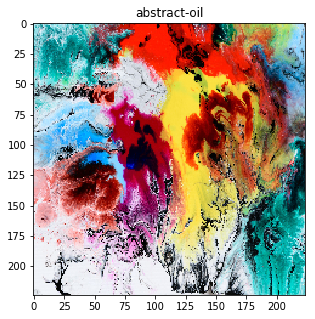

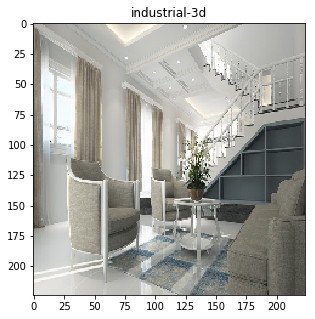

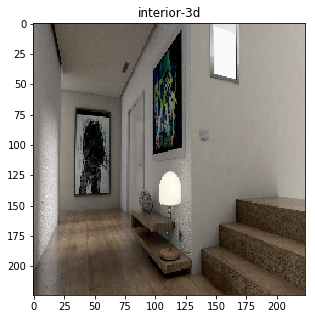

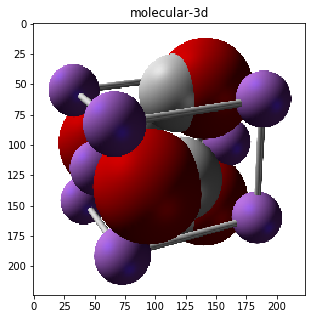

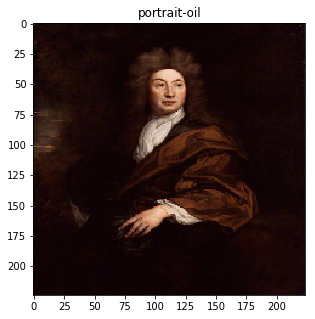

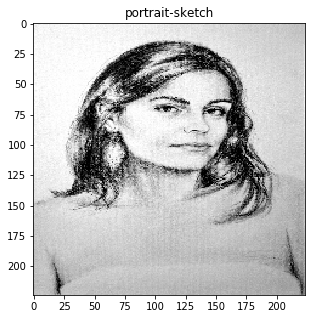

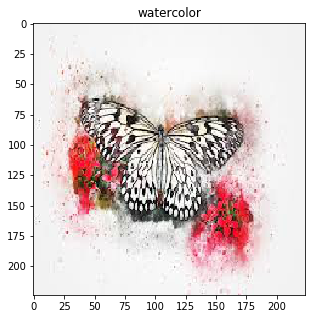

In [3]:
styles = [
    'abstract-oil',
    'industrial-3d',
    'interior-3d',
    'molecular-3d',
    'portrait-oil',
    'portrait-sketch',
    'watercolor',
]
art_by_style = {}
for style in styles:
    paths = glob.glob(f'../data/examples/{style}_*')
    art_by_style[style] = paths

for style, paths in art_by_style.items():
    img, _ = load_image(paths[0], (224, 224))
    plt.figure(figsize = (5, 5))
    plt.imshow(img)
    plt.title(style)

### Run Inference

In [4]:
model = VGG16(weights='imagenet', include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

predicted objects and probabilities
fountain: 0.14219287037849426
jellyfish: 0.08277028053998947
feather_boa: 0.08155087381601334
handkerchief: 0.0668238028883934
coral_reef: 0.06631910800933838


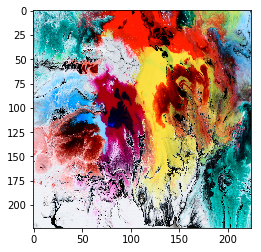

In [5]:

img, x = load_image(art_by_style['abstract-oil'][0], (224, 224))
plt.imshow(img)
predictions = model.predict(x)
print('predicted objects and probabilities')
for _, obj, prob in decode_predictions(predictions)[0]:
    print(f'{obj}: {prob}')

## Dense Layer Feature Extraction

Text(0.5,1,'normalized fc2 activations')

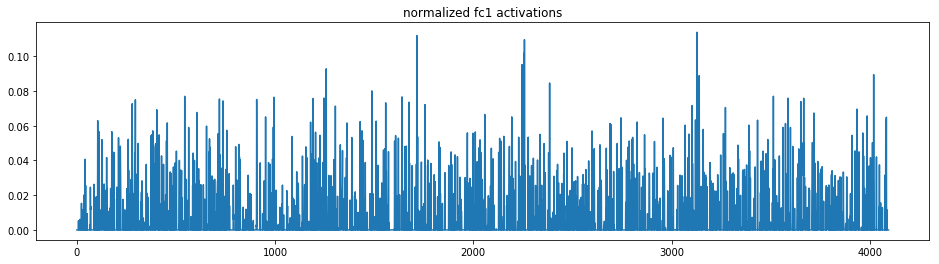

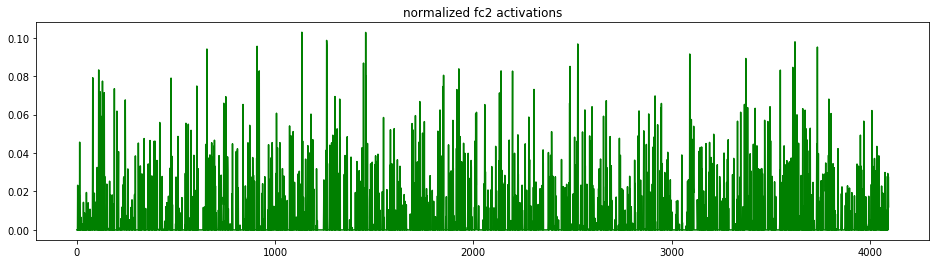

In [6]:
fc1_extractor = Model(inputs=model.input, outputs=model.get_layer('fc1').output)
fc2_extractor = Model(inputs=model.input, outputs=model.get_layer('fc2').output)
fc1_a = fc1_extractor.predict(x)
fc2_a = fc2_extractor.predict(x)
fc1_norm = preprocessing.normalize(fc1_a, norm='l2')
fc2_norm = preprocessing.normalize(fc2_a, norm='l2')
plt.figure(figsize=(16, 4))
plt.plot(fc1_norm[0])
plt.title('normalized fc1 activations')
plt.figure(figsize=(16, 4))
plt.plot(fc2_norm[0], color='green')
plt.title('normalized fc2 activations')

## Cosine Similarity
### Encoding Image Library

In [7]:
all_paths = [path for paths in list(art_by_style.values()) for path in paths]
file_mapping = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)
V_2 = fc2_extractor.predict(X)
V_1_norm = preprocessing.normalize(V_1, norm='l2')
V_2_norm = preprocessing.normalize(V_2, norm='l2')

### Build FAISS index and Query

In [8]:
def similarity_search(V_norm, v_query, n_results=6):
    v_query = np.expand_dims(v_query, axis=0)
    d = V_norm.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(np.ascontiguousarray(V_norm))
    distances, closest_indices = index.search(v_query, n_results)
    distances = distances.flatten()
    closest_indices = closest_indices.flatten()
    closest_paths = [file_mapping[idx] for idx in closest_indices]
    query_img = get_concatenated_images([file_mapping[query_idx]])
    results_img = get_concatenated_images(closest_paths)

    plt.figure(figsize=(5, 5))
    plt.imshow(query_img)
    plt.title('query image')

    plt.figure(figsize=(16, 12))
    plt.imshow(results_img)
    plt.title(f'results similarities: {distances}')
    plt.show()

fc1 results


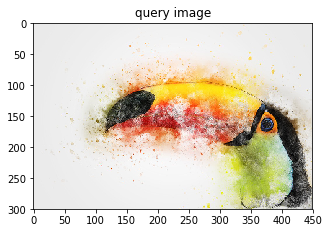

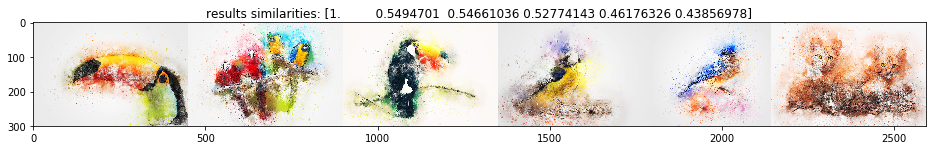

fc2 results


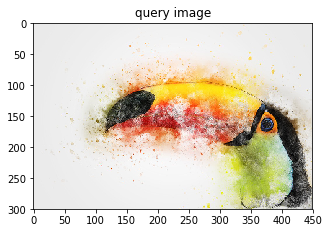

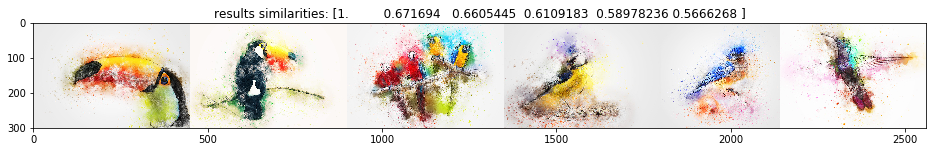

In [128]:
query_idx = 45
v_1_query = V_1_norm[query_idx]
v_2_query = V_2_norm[query_idx]

print('fc1 results')
similarity_search(V_1_norm, v_1_query)
print('fc2 results')
similarity_search(V_2_norm, v_2_query)

### Residuals 

In [70]:
class ImageFeatureOperator:
    def __init__(self, V_dict):
        self.V_dict = V_dict
        self.classes = list(V_dict)
        
    @classmethod
    def build(cls, img_by_class, extractor):
        V_dict = {}
        for class_, paths in img_by_class.items():
            x_list = [load_image(path, extractor.input_shape[1:3])[1] for path in paths]
            X = np.vstack(x_list)
            V = extractor.predict(X)
            V_dict[class_] = V
        inst = cls(V_dict)
        return inst
    
    @property
    def V_norm_dict(self):
        d = {}
        for class_, V in self.V_dict.items():
            V_norm = preprocessing.normalize(V, norm='l2')
            d[class_] = V_norm
        return d
        
    @property
    def V_norm_mean_dict(self):
        # normalize then mean
        d = {}
        for class_, V_norm in self.V_norm_dict.items():
            V_norm_mean = np.mean(V_norm, axis=0)
            d[class_] = V_norm_mean
        return d
    
    @property
    def V_mean_norm_dict(self):
        d = {}
        for class_, V in self.V_dict.items():
            V_mean = np.mean(V, axis=0)
            V_mean = np.expand_dims(V_mean, axis=0)
            V_mean_norm = preprocessing.normalize(V_mean, norm='l2')
            V_mean_norm = V_mean_norm.flatten()
            d[class_] = V_mean_norm
        return d
    
    @property
    def V_norm_mean_res_dict(self):
        V_norm_mean_avg = np.mean(np.stack(list(self.V_norm_mean_dict.values())), axis=0)
        d = {class_: V_norm_mean_avg - mean for class_, mean in self.V_norm_mean_dict.items()}
        return d
        
    @property
    def V_mean_norm_res_dict(self):
        V_mean_norm_avg = np.mean(np.stack(list(self.V_mean_norm_dict.values())), axis=0)
        d = {class_: V_mean_norm_avg - mean for class_, mean in self.V_mean_norm_dict.items()}
        return d
    
    @property
    def avg_intraclass_dist_dict(self):
        d = {}
        for class_, V_norm in self.V_norm_dict.items():
            dist_arr = np.array([])
            dim = V_norm.shape[1]
            index = faiss.IndexFlatIP(dim)
            index.add(np.ascontiguousarray(V_norm))
            for i, v in enumerate(V_norm[:-1]):
                ref_idx = i + 1
                V_ref = V_norm[ref_idx:]
                V_ref_indices = list(range(ref_idx, ref_idx + len(V_ref)))
                v = np.expand_dims(v, axis=0)
                labels_iter_range = list(range(1, len(V_ref) + 1))
                labels = np.array([V_ref_indices, labels_iter_range])
                distances = np.empty((1, len(V_ref)), dtype='float32')
                index.compute_distance_subset(
                    1, faiss.swig_ptr(v), len(V_ref),
                    faiss.swig_ptr(distances), faiss.swig_ptr(labels))
                distances = distances.flatten()
                dist_arr = np.append(dist_arr, distances)
            print(f'intraclass distances: {dist_arr}')
            avg_dist = np.mean(dist_arr)
            d[class_] = avg_dist
        return d

    @property
    def mean_avg_intraclass_dist(self):
        return np.mean(self.avg_intraclass_dist_dict.values())
    
    @property
    def avg_interclass_centroid_dist_dict(self):
        # Should I use norm_mean or mean_norm for centroid?
        d = {}
        class_list = []
        v_list = []
        # TODO: TEMPORARILY CHANGED TO V_mean_norm
        for class_, v in self.V_mean_norm_dict.items():
            class_list.append(class_)
            v_list.append(v)
        V_norm_mean = np.stack(v_list)
        
        dim = V_norm_mean.shape[1]
        index = faiss.IndexFlatIP(dim)
        index.add(np.ascontiguousarray(V_norm_mean))
        
        for i, v in enumerate(V_norm_mean):
            V_ref_indices = list(chain(range(0, i), range(i + 1, len(V_norm_mean))))
            v = np.expand_dims(v, axis=0)
            labels_iter_range = list(range(1, len(V_norm_mean)))
            labels = np.array([list(V_ref_indices), labels_iter_range])
            distances = np.empty((1, len(V_norm_mean) - 1), dtype='float32')
            index.compute_distance_subset(
                1, faiss.swig_ptr(v), len(V_norm_mean),
                faiss.swig_ptr(distances), faiss.swig_ptr(labels))
            distances = distances.flatten()
            print(f'centroid distances: {distances}')
            avg_dist = np.mean(distances)
            d[class_list[i]] = avg_dist
        return d
    
    @property
    def new_avg_interclass_dist_dict(self):
        d = {}
        class_indices = {}
        i = 0
        V_norm = np.vstack(self.V_norm_dict.values())
        dim = V_norm.shape[1]
        index = faiss.IndexFlatIP(dim)
        index.add(np.ascontiguousarray(V_norm))
        for class_, V_norm_class in self.V_norm_dict.items():
            class_indices = {class_: list(range(i, len(V_norm_class)))}
            distances, closest_indices = index.search(V_norm_class, len(V_norm))
            set_trace()
            
    @property
    def silhouette_score(self):
        V_list = []
        labels = []
        for class_, class_V in self.V_dict.items():
            labels += len(class_V) * [class_]
            V_list.append(class_V)
        V = np.vstack(V_list)
        score = silhouette_score(V, labels, metric='cosine')    
        return score
    
    @property
    def mean_avg_interclass_centroid_dist(self):
        return np.mean(self.avg_interclass_centroid_dist_dict.values())
    
    @property
    def iicr_dict(self):
        d = {}
        intraclass_dist_dict = self.avg_intraclass_dist_dict
        avg_interclass_centroid_dist_dict = self.avg_interclass_centroid_dist_dict
        for class_ in self.classes:
            intraclass_dist = intraclass_dist_dict[class_]
            interclass_centroid_dist = avg_interclass_centroid_dist_dict[class_]
            d[class_] = intraclass_dist / interclass_centroid_distv 
        return d
    
    @property
    def mean_iicr(self):
        return np.mean(self.iicr_dict.values())

In [71]:
V_1_operator = ImageFeatureOperator.build(art_by_style, fc1_extractor)
V_2_operator = ImageFeatureOperator.build(art_by_style, fc2_extractor)

Normalize then mean

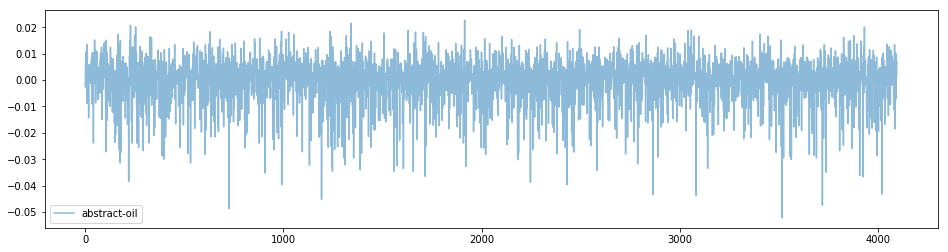

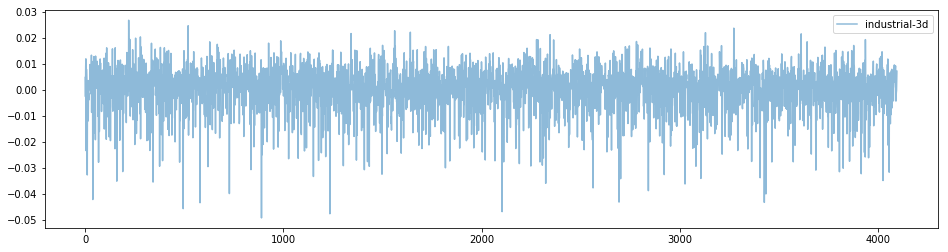

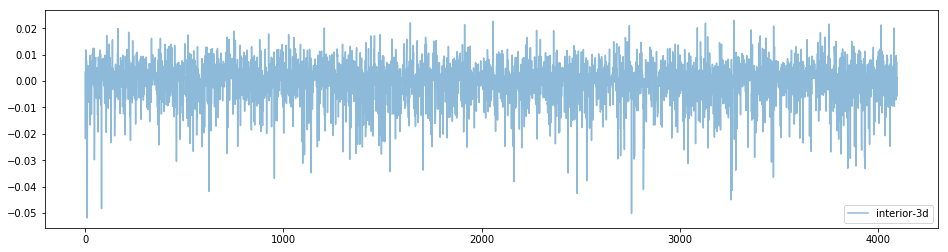

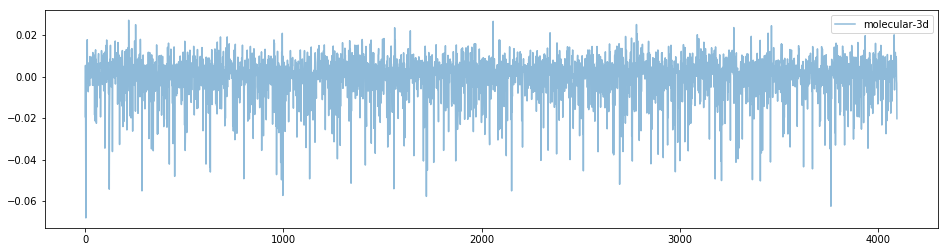

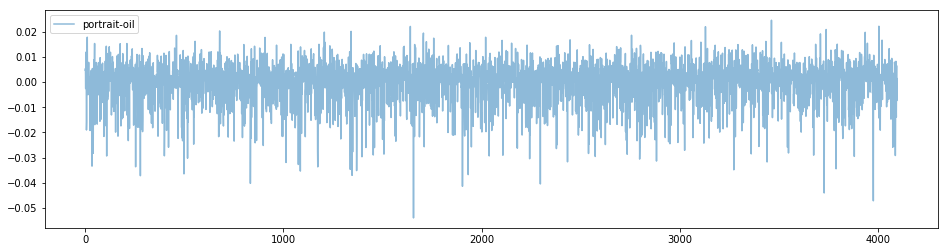

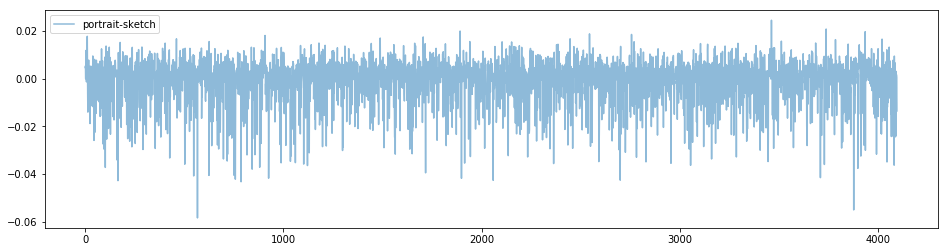

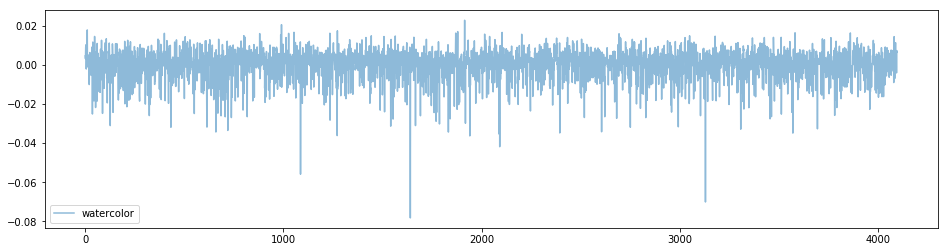

In [72]:
for style, res in V_1_operator.V_norm_mean_res_dict.items():
    plt.figure(figsize=(16, 4))

    plt.plot(res, alpha=0.5, label=style)
    plt.legend()
    plt.show()

Mean then normalize

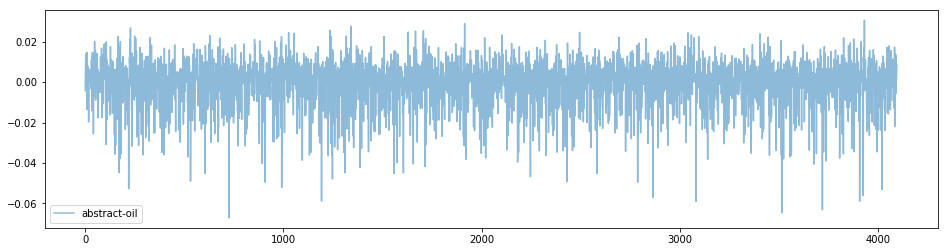

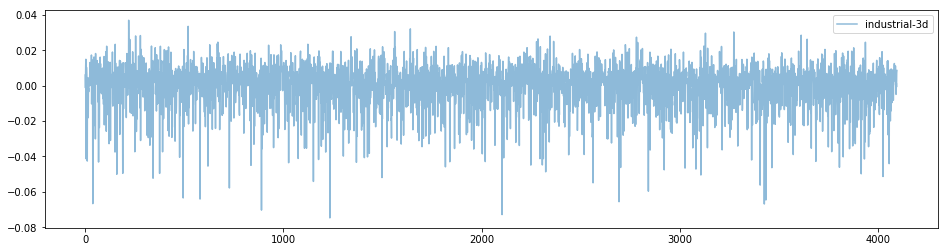

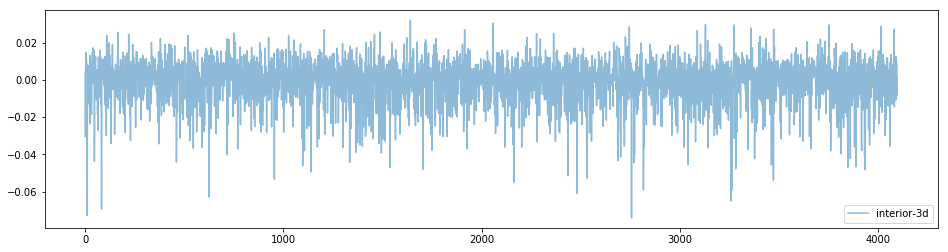

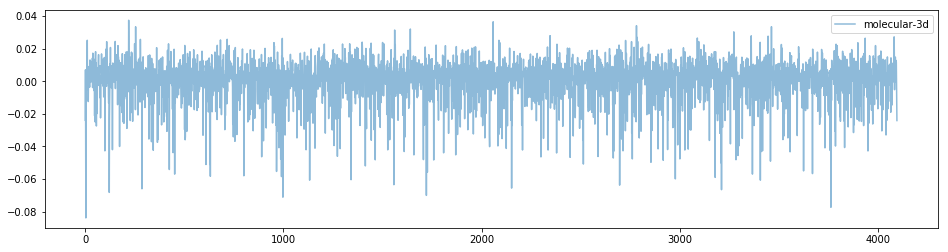

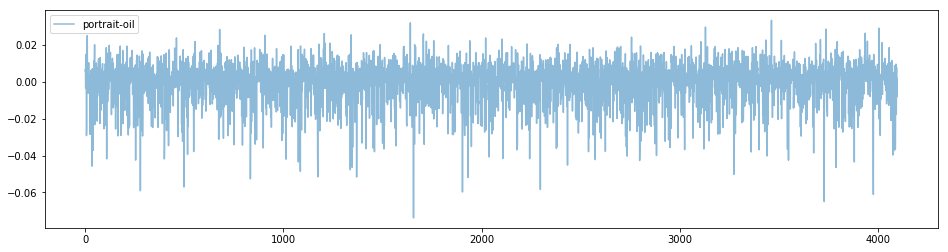

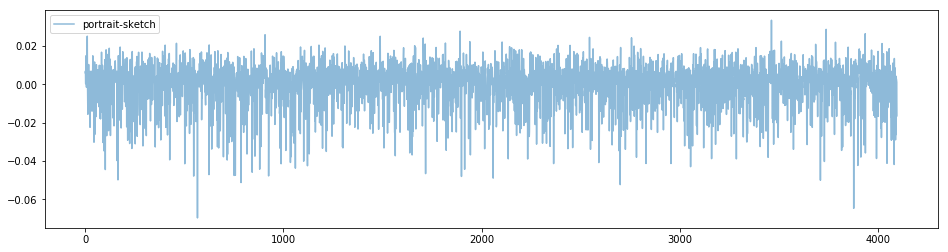

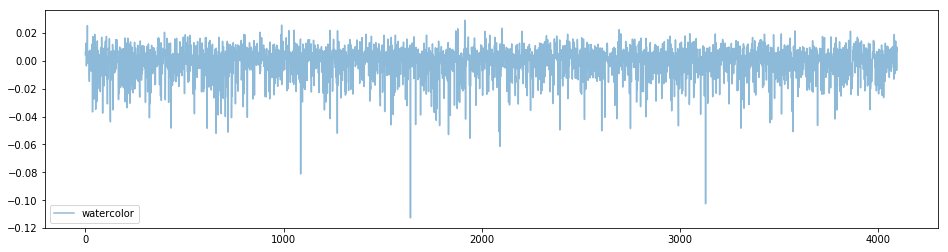

In [73]:
for style, res in V_1_operator.V_mean_norm_res_dict.items():
    plt.figure(figsize=(16, 4))

    plt.plot(res, alpha=0.5, label=style)
    plt.legend()
    plt.show()

### Clustering Metrics

In [74]:
print(V_1_operator.silhouette_score)

0.20982932


### PCA

In [75]:
# do similarity search

In [111]:
class PCAOperator(ImageFeatureOperator):
    @classmethod
    def build(cls, img_by_class, extractor, n_components):
        V_dict = {}
        for class_, paths in img_by_class.items():
            x_list = [load_image(path, extractor.input_shape[1:3])[1] for path in paths]
            X = np.vstack(x_list)
            V = extractor.predict(X)
            V_dict[class_] = V
        V_pca_dict = cls.pca(V_dict, n_components)
        inst = cls(V_pca_dict)
        return inst

    @staticmethod
    def pca(V_dict, n_components):
        V = np.vstack(V_dict.values())
        n_samples = V.shape[0]
        if n_samples < n_components:
            print(f'PCA: using {n_samples} rather than {n_components} due to limited sample number')
            n_components = n_samples
        transformer = PCA(n_components)
        transformer.fit(V)
        V_pca_dict = {class_: transformer.transform(class_V) for class_, class_V in V_dict.items()}
        return V_pca_dict

In [112]:
pca_fc2_operator = PCAOperator.build(art_by_style, fc2_extractor, 200)
pca_fc2_operator.silhouette_score

PCA: using 49 rather than 200 due to limited sample number


0.23971654

### NOTE: Even though silhouette score uses cosine, using V_norm_dict (below) yields different results

In [114]:
n_components = 200
n_components = min(V_2.shape[0], 200)

transformer_1 = PCA(n_components)
transformer_2 = PCA(n_components)
transformer_1.fit(V_1)
transformer_2.fit(V_2)

V_1_pca_dict = {class_: transformer_1.transform(V_norm) for class_, V_norm in V_1_operator.V_norm_dict.items()}
V_2_pca_dict = {class_: transformer_2.transform(V_norm) for class_, V_norm in V_2_operator.V_norm_dict.items()}

V_1_pca_operator = ImageFeatureOperator(V_1_pca_dict)
V_2_pca_operator = ImageFeatureOperator(V_2_pca_dict)

# V_1_pca_operator.silhouette_score
V_2_pca_operator.silhouette_score

0.25074723

### Conv and Pool Feature Extraction

In [77]:
b2p_extractor = Model(inputs=model.input, outputs=model.get_layer('block2_conv2').output)
V_b2p = b2p_extractor.predict(X)
V_b2p.shape

(49, 112, 112, 128)

### Gram Matrix

In [78]:
def gram_matrix(x):
    if np.ndim(x) == 4 and x.shape[0] == 1:
        x = x[0, :]
    elif np.ndim(x) != 3:
        raise ValueError(f'bad shape: {x.shape}, ndim = {np.ndim(x)}')
    x = x.reshape(x.shape[-1], -1)
    gram_mat = np.dot(x, np.transpose(x))
    return gram_mat

<Figure size 360x360 with 0 Axes>

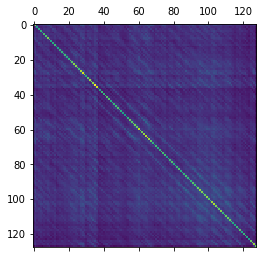

In [79]:
example_v = V_b2p[0]
example_gram = gram_matrix(example_v)
plt.figure(figsize=(5, 5))
plt.matshow(example_gram)

### Diagonal

In [80]:
def diagonal(V):
    return np.diagonal(V, axis1=1, axis2=2)

In [81]:
class GramDiagOperator(ImageFeatureOperator):
    @classmethod
    def build(cls, img_by_class, extractor):
        V_dict = {}
        for class_, paths in img_by_class.items():
            x_list = [load_image(path, extractor.input_shape[1:3])[1] for path in paths]
            X = np.vstack(x_list)
            V = extractor.predict(X)
            
            V_gram_list = []
            for v in V:
                gram = gram_matrix(v)
                V_gram_list.append(gram)
            V_gram = np.stack(V_gram_list)
            V_gram_diag = np.diagonal(V_gram, axis1=1, axis2=2)

            V_dict[class_] = V_gram_diag
        inst = cls(V_dict)
        return inst

In [82]:
diag_operator_b2p = GramDiagOperator.build(art_by_style, b2p_extractor)
diag_operator_b2p.silhouette_score

-0.07183966

### Gram Matrix (using lower triangle)

<Figure size 360x360 with 0 Axes>

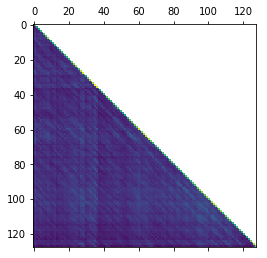

In [83]:
mask = np.triu_indices(len(example_gram), 1)
example_gram[mask] = None
plt.figure(figsize=(5, 5))
plt.matshow(example_gram)

<Figure size 360x360 with 0 Axes>

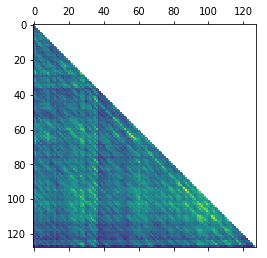

In [84]:
mask = np.triu_indices(len(example_gram), 0)
example_gram[mask] = None
plt.figure(figsize=(5, 5))
plt.matshow(example_gram)

In [85]:
class GramOperator(ImageFeatureOperator):
    @classmethod
    def build(cls, img_by_class, extractor, include_diag):
        V_dict = {}
        for class_, paths in img_by_class.items():
            x_list = [load_image(path, extractor.input_shape[1:3])[1] for path in paths]
            X = np.vstack(x_list)
            V = extractor.predict(X)
            
            V_gram_list = []
            for v in V:
                gram = cls.gram_vector(v, include_diag)
                V_gram_list.append(gram)
            V_gram = np.stack(V_gram_list)
            V_dict[class_] = V_gram
        inst = cls(V_dict)
        return inst
    
    @staticmethod
    def gram_vector(x, include_diag=True):
        gram_mat = gram_matrix(x)
        if include_diag:
            offset = 1
        else:
            offset = 0
        mask = np.triu_indices(len(gram_mat), offset)
        gram_mat[mask] = None
        gram_vec = gram_mat.flatten()
        gram_vec = gram_vec[~np.isnan(gram_vec)]
        return gram_vec

In [86]:
gram_operator_b2p_incl_diag = GramOperator.build(art_by_style, b2p_extractor, include_diag=True)
gram_operator_b2p_incl_diag.silhouette_score

-0.051633786

In [87]:
gram_operator_b2p_incl_diag = GramOperator.build(art_by_style, b2p_extractor, include_diag=False)
gram_operator_b2p_incl_diag.silhouette_score

-0.08734061

In [120]:
class GramPCAOperator(GramOperator, PCAOperator):
    @classmethod
    def build(cls, img_by_class, extractor, include_diag, n_components):
        V_dict = {}
        for class_, paths in img_by_class.items():
            x_list = [load_image(path, extractor.input_shape[1:3])[1] for path in paths]
            X = np.vstack(x_list)
            V = extractor.predict(X)
            
            V_gram_list = []
            for v in V:
                gram = cls.gram_vector(v, include_diag)
                V_gram_list.append(gram)
            V_gram = np.stack(V_gram_list)
            V_dict[class_] = V_gram
        V_pca_dict = cls.pca(V_dict, n_components)
        inst = cls(V_pca_dict)
        return inst

In [129]:
b2p_extractor = Model(inputs=model.input, outputs=model.get_layer('block3_conv3').output)
gram_pca_operator = GramPCAOperator.build(art_by_style, b2p_extractor, False, 200)
gram_pca_operator.silhouette_score

PCA: using 49 rather than 200 due to limited sample number


-0.007541108

In [ ]:
class ConcatGramPCAOperator(GramPCAOperator):
    @classmethod
    def build(cls, img_by_class, layer_extractors, include_diag, n_components):
        V_dict = {}
        for class_, paths in img_by_class.items():
            for name, layer_extractor in layer_extractors.items():
                x_list = [load_image(path, layer_extractor.input_shape[1:3])[1] for path in paths]
                X = np.vstack(x_list)
                V = layer_extractor.predict(X)

In [ ]:
layers_extractors = dict([(layer.name, layer.output) for layer in model.layers])


In [77]:
V_b2p_gram_norm = preprocessing.normalize(V_b2p_gram, norm='l2')

b2p results


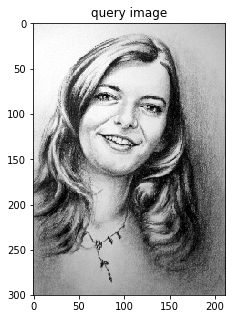

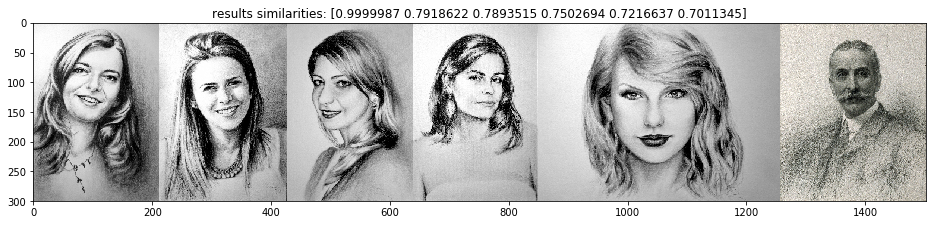

In [78]:
query_idx = 30
v_b2p_gram_query = V_b2p_gram_norm[query_idx]

print('b2p results')
similarity_search(V_b2p_gram_norm, v_b2p_gram_query)

Build

In [2]:
stack = StyleStack.build('../data/test/', 'vgg16')

keeping 14 image_paths to analyze
index time: 319.979 ms


Query

In [3]:
# query params
lib_name = 'test'
n_results = 6
query_path = '../data/test/142362-Louis-Vuitton-Signature-Collection__pean.jpg'

embedding_weights = {
        'block1_conv1': 1,
        'block1_conv2': 1,
        'block1_pool': 0.5,
}

# query
results = stack.query(query_path, embedding_weights, n_results)

{'block1_conv1': {0: 0.8162589, 1: 0.5983292, 2: 0.12297328, 6: 0.2630302, 8: 0.0, 9: 1.0, 12: 0.6130022, 13: 0.25608045}, 'block1_conv2': {0: 0.51677495, 1: 0.37969384, 2: 0.14565201, 6: 1.0, 8: 0.0, 9: 0.33169997, 12: 0.3618313, 13: 0.30481035}, 'block1_pool': {0: 0.4302553, 1: 0.74339443, 2: 0.14084846, 6: 1.0, 8: 0.0, 9: 0.27688542, 12: 0.6988181, 13: 0.25653794}}
{0: 1.548161506652832, 1: 1.3497202396392822, 2: 0.3390495181083679, 6: 1.7630302011966705, 8: 0.0, 9: 1.4701426774263382, 12: 1.3242425322532654, 13: 0.6891597658395767}
query time: 30.756 ms
[8, 2, 13, 12, 1, 9]


Save

In [4]:
stack.save('test')
del stack

Reload and Query

In [5]:
stack = StyleStack.load(lib_name)
results = stack.query(query_path, embedding_weights, n_results)
del stack

{'block1_conv1': {0: 0.8162589, 1: 0.5983292, 2: 0.12297328, 6: 0.2630302, 8: 0.0, 9: 1.0, 12: 0.6130022, 13: 0.25608045}, 'block1_conv2': {0: 0.51677495, 1: 0.37969384, 2: 0.14565201, 6: 1.0, 8: 0.0, 9: 0.33169997, 12: 0.3618313, 13: 0.30481035}, 'block1_pool': {0: 0.4302553, 1: 0.74339443, 2: 0.14084846, 6: 1.0, 8: 0.0, 9: 0.27688542, 12: 0.6988181, 13: 0.25653794}}
{0: 1.548161506652832, 1: 1.3497202396392822, 2: 0.3390495181083679, 6: 1.7630302011966705, 8: 0.0, 9: 1.4701426774263382, 12: 1.3242425322532654, 13: 0.6891597658395767}
query time: 27.106 ms
[8, 2, 13, 12, 1, 9]


Plot

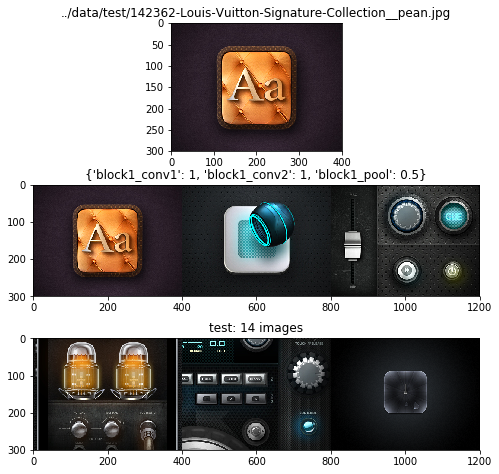

In [6]:
plot_results(results)